# ClimateHack.AI 2023: Training a Basic Model

Thank you for participating in ClimateHack.AI 2023! 🌍

Your contributions could help cut carbon emissions by up to 100 kilotonnes per year in Great Britain alone. We look forward to seeing what you build over the course of the competition!

In this Jupyter notebook, you will hopefully train your first model for the challenge using historical solar PV data and HRV satellite imagery.

For more detailed information on the challenge, see the [DOXA AI competition page](https://doxaai.com/competition/climatehackai-2023/overview). 😎

## Installing packages

Before you can get started, you will need to install a number of packages to allow you to work with the data and submit to the platform. If you do not already have these packages installed, you can uncomment the lines below to do so! You will also need to [install PyTorch](https://pytorch.org/get-started/locally/).

In [1]:
#%pip install numpy matplotlib zarr xarray ipykernel gcsfs fsspec dask cartopy ocf-blosc2 torchinfo
#%pip install -U doxa-cli

Note: you may need to restart the kernel to use updated packages.


  Using cached requests-2.26.0-py2.py3-none-any.whl (62 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: doxa-cli
    Found existing installation: doxa-cli 0.1.5
    Uninstalling doxa-cli-0.1.5:
      Successfully uninstalled doxa-cli-0.1.5
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.11.1 requires ruamel-yaml, which is not installed.
translate-json 0.0.2 requires certifi==2021.5.30, but you have certifi 2023.5.7 which is incompatible.
translate-json 0.0.2 requires idna==3.2; python_version >= "3", but you have idna 2.10 which is incompatible.
osmnx 1.9.1 requires requests>=2.27, but you have requests 2.26.0 which is incompatible.
conda-repo-cli 1.0.20 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.20 requires nbformat==5.4.0, but you have nbformat 5.5.0 which is incompatible.
conda-repo-cli 1.0.20 requires requests==2.28.1, but you have requests 2.26.0 which is incompatible.


## Importing packages

Here, we import a number of packages we will need to train our first model.

In [1]:
import os
from datetime import datetime, time, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import xarray as xr
from ocf_blosc2 import Blosc2
from torch.utils.data import DataLoader, IterableDataset
from torchinfo import summary
import json
import geopandas as gpd
import seaborn as sns
from scipy.ndimage import zoom
import numpy as np

plt.rcParams["figure.figsize"] = (20, 12)

c:\Users\james\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\james\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\james\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

## Creating your submission directory

If you cloned [this repository](https://github.com/climatehackai/getting-started-2023) straight from GitHub, you will already have all the files you need, but if you are running this notebook using Google Colab, we just need to download a couple extra files to create a fresh submission directory that you will soon hopefully be in a position to upload to the platform as part of your first competition submission.


In [3]:
if not os.path.exists("submission"):
     os.makedirs("submission", exist_ok=True)
     #Installing locally means you do not need to rerun this each time you restart the notebook
     !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/submission/competition.py --output submission/competition.py
     !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/submission/doxa.yaml --output submission/doxa.yaml
     !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/submission/model.py --output submission/model.py
     !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/submission/run.py --output submission/run.py
     !curl -L https://raw.githubusercontent.com/climatehackai/getting-started-2023/main/indices.json --output indices.json

## Downloading a month of data

While streaming the Zarr-format datasets directly from Hugging Face was adequate for some initial data exploration in `1_data.ipynb`, it most likely will not be fast enough in training. Since there is so much data available, we can get started just by downloading a single month of PV and HRV satellite imagery data.

In [4]:
if not os.path.exists("data"):
    os.makedirs("data/pv/2020", exist_ok=True)
    os.makedirs("data/satellite-hrv/2020", exist_ok=True)

    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/pv/metadata.csv --output data/pv/metadata.csv
    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/pv/2020/7.parquet --output data/pv/2020/7.parquet
    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/satellite-hrv/2020/7.zarr.zip --output data/satellite-hrv/2020/7.zarr.zip

## Loading the data

In [5]:
pv_kwh = pd.read_parquet("data/pv/2020/7.parquet")#used for generating charts
pv_kwh

generation_wh  power
timestamp                 ss_id                      
2020-07-01 00:00:00+00:00 2607             0.0    0.0
                          2626             0.0    0.0
                          2631             0.0    0.0
                          2657             0.0    0.0
                          2729             0.0    0.0
...                                        ...    ...
2020-07-31 23:55:00+00:00 27062            0.0    0.0
                          27063            0.0    0.0
                          27064            0.0    0.0
                          27065            0.0    0.0
                          27066            0.0    0.0

[7827134 rows x 2 columns]

In [6]:
pv = pd.read_parquet("data/pv/2020/7.parquet").drop("generation_wh", axis=1)
#The parquet data here is similar to a dataframe. The "power" is the column with the other data types being indexes. The data is shaped with each timestamp being its own sub frame with the sites having their corresponding power (I think this is the % of their total possible yield).  
pv

power
timestamp                 ss_id       
2020-07-01 00:00:00+00:00 2607     0.0
                          2626     0.0
                          2631     0.0
                          2657     0.0
                          2729     0.0
...                                ...
2020-07-31 23:55:00+00:00 27062    0.0
                          27063    0.0
                          27064    0.0
                          27065    0.0
                          27066    0.0

[7827134 rows x 1 columns]

####################This block is used for plotting, you do not need to run this block to run the models############################


In [6]:
#Note that not all the sites in the PV sets line up with the sites in the indices set later on so not all of them can be plotted using a CRS system as the pv object has the CRS coordinates for some and not all of the sites. This is not an issue for the model but is for plotting all the sites on a mao should we want to include this.
####################This block is used for plotting, you do not need to run this block to run the models############################
#here I am getting the long and lat for all of our sites in the data set so that they can be plotted
pv_ss_id = pv.index.get_level_values("ss_id").unique()
pv_ss_time = pv.index.get_level_values("timestamp")
pv_meta = pd.read_csv("data/pv/metadata.csv")
pv_meta_ssid = pv_meta.ss_id
shared_id = [x for x in pv_ss_id if x in pv_meta_ssid]
pv_shared = pv_meta[pv_meta["ss_id"].isin(shared_id)] #shared location data, only 698 of 908 sites in the pv file have long and lat for plotting


# Getting the average daily power yield for each site 
pv_kwh_y = pv_kwh.reset_index()
pv_kwh_y = pv_kwh_y.set_index('timestamp')

average_daily_kwh_yield = pv_kwh_y.groupby(['ss_id', pd.Grouper(freq='D')]).mean()

average_daily_kwh_yield = average_daily_kwh_yield.reset_index().drop(columns={"timestamp"}).rename(columns={"generation_wh":"generation_wh_avg"})

average_daily_kwh_yield = average_daily_kwh_yield.groupby("ss_id")["generation_wh_avg"].mean().reset_index()


# Getting the average daily kwh yield for each site 
pv_y = pv.reset_index()
pv_y = pv_y.set_index('timestamp')

average_daily_yield = pv_y.groupby(['ss_id', pd.Grouper(freq='D')]).mean()

average_daily_yield = average_daily_yield.reset_index().drop(columns={"timestamp"}).rename(columns={"power":"avg_power"})

average_daily_yield = average_daily_yield.groupby("ss_id")["avg_power"].mean().reset_index()

#merging dfs
pv_shared = pv_shared.merge(average_daily_yield, on="ss_id", how="left").dropna() #final output of the metadata file that contains the average daily yield for different sites
pv_shared = pv_shared.merge(average_daily_kwh_yield, on="ss_id", how="left").dropna() 

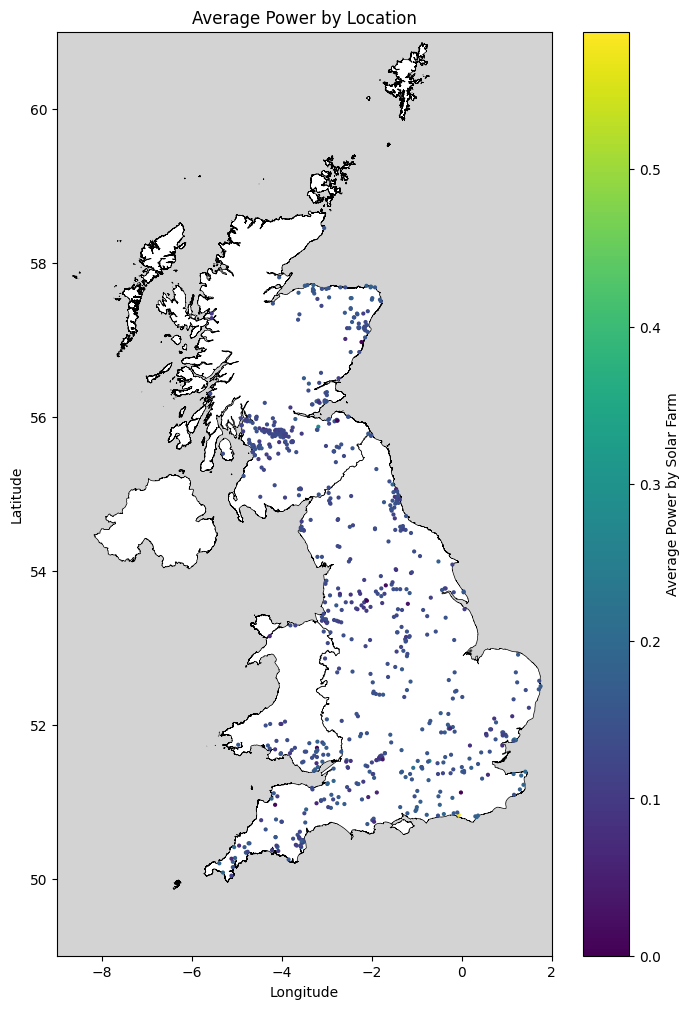

In [62]:
gdf = gpd.GeoDataFrame(
    pv_shared, geometry=gpd.points_from_xy(pv_shared.longitude_rounded, pv_shared.latitude_rounded)
)
gdf = gdf.set_crs("EPSG:4326")
uk_shp = r"C:\Users\james\OneDrive - University of Bristol\Desktop\UCL\aml\data\uk_shape"
uk = gpd.read_file(uk_shp)
uk = uk.to_crs(gdf.crs)

fig, ax = plt.subplots(1, 1, figsize=(8, 12))
ax.set_facecolor('lightgrey')

uk.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)

gdf.plot(ax=ax, column='avg_power', cmap='viridis', markersize=4, legend=True, legend_kwds={'label': 'Average Power by Solar Farm', 'orientation': "vertical"})

ax.set_xlim([-9, 2])
ax.set_ylim([49, 61])

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Average Power by Location')

plt.show()

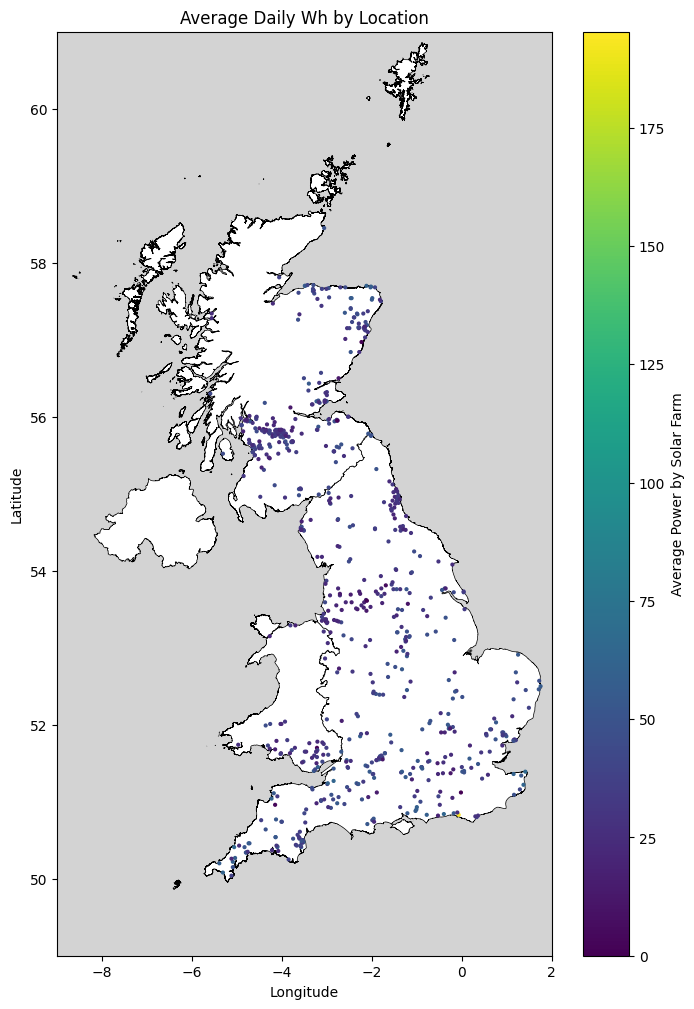

In [71]:
gdf = gpd.GeoDataFrame(
    pv_shared, geometry=gpd.points_from_xy(pv_shared.longitude_rounded, pv_shared.latitude_rounded)
)
gdf = gdf.set_crs("EPSG:4326")
uk_shp = r"C:\Users\james\OneDrive - University of Bristol\Desktop\UCL\aml\data\uk_shape"
uk = gpd.read_file(uk_shp)
uk = uk.to_crs(gdf.crs)

fig, ax = plt.subplots(1, 1, figsize=(8, 12))
ax.set_facecolor('lightgrey')

uk.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)

gdf.plot(ax=ax, column='generation_wh_avg', cmap='viridis', markersize=4, legend=True, legend_kwds={'label': 'Average Power by Solar Farm', 'orientation': "vertical"})

ax.set_xlim([-9, 2])
ax.set_ylim([49, 61])

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Average Daily Wh by Location')

plt.show()

Creating charts for daily yield

In [74]:
pvc = pv.reset_index()
pvc['timestamp'] = pd.to_datetime(pvc['timestamp'])

pvc['hour_of_day'] = pvc['timestamp'].dt.hour

In [80]:
pvc_hour = pvc.groupby(['ss_id', 'hour_of_day'])['power'].mean().round(2).reset_index().rename(columns={"power":"avg_power"})
pvc_hour

,ss_id,hour_of_day,avg_power
0,2607,0,0.0
1,2607,1,0.0
2,2607,2,0.0
3,2607,3,0.0
4,2607,4,0.0
...,...,...,...
21735,27066,19,0.0
21736,27066,20,0.0
21737,27066,21,0.0
21738,27066,22,0.0


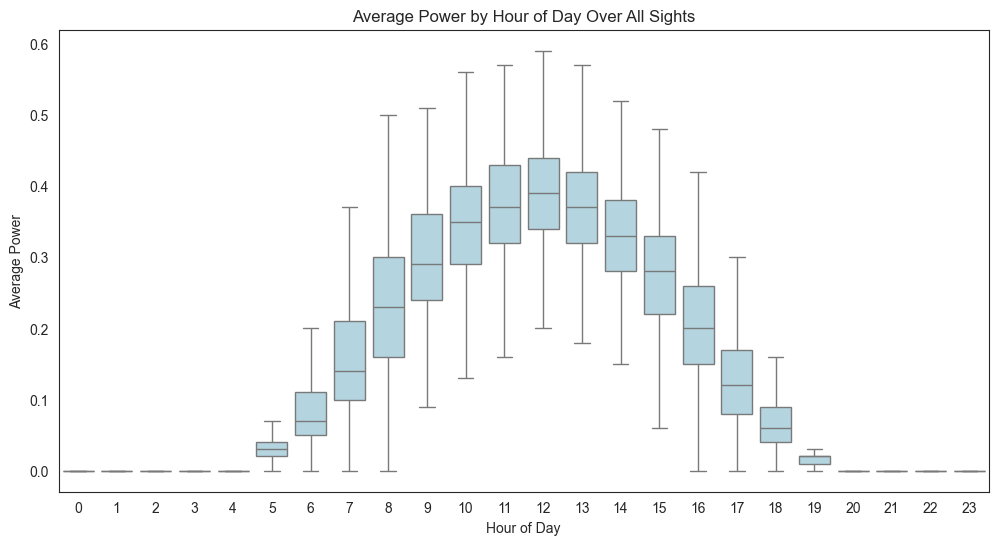

In [93]:
sns.set_style("white")

plt.figure(figsize=(12, 6))

ax = sns.boxplot(x='hour_of_day', y='avg_power', data=pvc_hour, showfliers=False, color="lightblue")


plt.title('Average Power by Hour of Day Over All Sights')
plt.xlabel('Hour of Day')
plt.ylabel('Average Power')

# Set x-ticks to be every hour
plt.xticks(range(0, 24))  # Set this according to your actual hour range

# Display the plot
plt.show()

In [25]:
hrv = xr.open_dataset(
    "data/satellite-hrv/2020/7.zarr.zip", engine="zarr", chunks="auto"
)
#The way that this works is that it stores the image as a vector. The vectors are stored as an array of vectors. These then have a timestamp, as we only have one channel the array is a 1D set of vectors with the dimension being time. Read this to help you understand how this is being stored https://tutorial.xarray.dev/fundamentals/01_datastructures.html
# To access I have included some examples below
#The float value (float16-float64) shows the precision with which data is stored. Later on it is important to make sure that when you are feeding in data into the model that the float type matches between data types, this currently is not a problem when only using the HRV data. I am not yet sure if this will be a problem when using the NWP data.

hrv

<xarray.Dataset>
Dimensions:                      (channel: 1, time: 6721, y_geostationary: 592, x_geostationary: 684)
Coordinates:
  * channel                      (channel) <U3 'HRV'
  * time                         (time) datetime64[ns] 2020-07-01T04:00:00 .....
  * x_geostationary              (x_geostationary) float64 -1.089e+06 ... -4....
  * y_geostationary              (y_geostationary) float64 4.449e+06 ... 5.04...
Data variables:
    data                         (time, y_geostationary, x_geostationary, channel) float16 dask.array<chunksize=(143, 592, 684, 1), meta=np.ndarray>
    x_geostationary_coordinates  (time, x_geostationary) float64 dask.array<chunksize=(6721, 684), meta=np.ndarray>
    y_geostationary_coordinates  (time, y_geostationary) float64 dask.array<chunksize=(6721, 592), meta=np.ndarray>

In [26]:
hrv["data"] #This stores all of the data within this channel as a 16 bit set of floats with 47 chunks. The cube on the side shows how the each image is stored.

,Array,Chunk
Bytes,5.07 GiB,110.44 MiB
Shape,"(6721, 592, 684, 1)","(143, 592, 684, 1)"
Count,48 Tasks,47 Chunks
Type,float16,numpy.ndarray


In [39]:
print(hrv["time"][0])
print(hrv["time"][-1])
#There seems to be some discrepancy with the time dimensions beyond the resolution. Multiplying out the nwp dataset to 12x its size shows that there is some mismatch in the datasets, I am not sure why yet. 

<xarray.DataArray 'time' ()>
array('2020-07-01T04:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-07-01T04:00:00
<xarray.DataArray 'time' ()>
array('2020-07-31T22:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-07-31T22:00:00


To plot a specific tinestamp

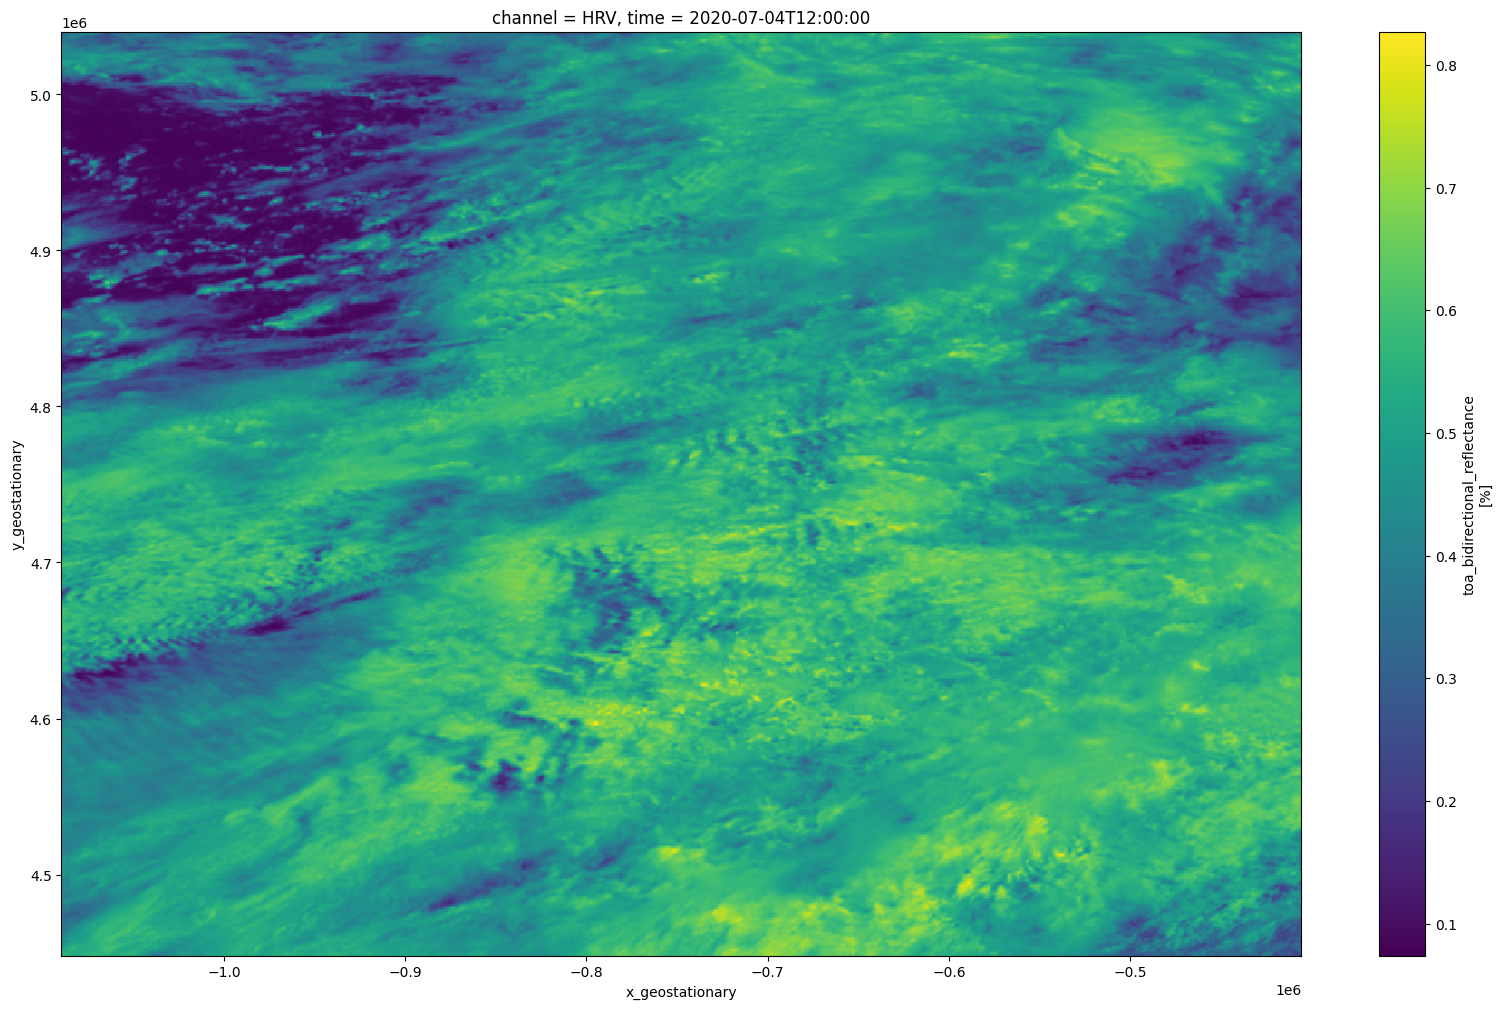

In [24]:
your_specific_datetime = '2020-07-04T12:00'
time_diff = np.abs(hrv['time'].values - np.datetime64(your_specific_datetime))

min_index = np.argmin(time_diff)

selected_data = hrv['data'].isel(time=min_index)

selected_data.plot()

Importing and treating the nwp data, this downloads quickly so no need to download locally

In [37]:
nwp = xr.open_dataset(
    "zip:///::https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/weather/2020/7.zarr.zip",
    engine="zarr",
    consolidated=True,
)
#note that this only covers one month in this download
nwp

<xarray.Dataset>
Dimensions:     (time: 513, latitude: 305, longitude: 289)
Coordinates:
  * latitude    (latitude) float64 45.0 45.06 45.12 45.19 ... 63.88 63.94 64.0
  * longitude   (longitude) float64 -11.0 -10.94 -10.88 ... 6.875 6.938 7.0
  * time        (time) datetime64[ns] 2020-07-01T04:00:00 ... 2020-07-31T22:0...
Data variables: (12/38)
    alb_rad     (time, latitude, longitude) float32 ...
    aswdifd_s   (time, latitude, longitude) float32 ...
    aswdir_s    (time, latitude, longitude) float32 ...
    cape_con    (time, latitude, longitude) float32 ...
    clch        (time, latitude, longitude) float32 ...
    clcl        (time, latitude, longitude) float32 ...
    ...          ...
    v_850       (time, latitude, longitude) float32 ...
    v_950       (time, latitude, longitude) float32 ...
    vmax_10m    (time, latitude, longitude) float32 ...
    w_snow      (time, latitude, longitude) float32 ...
    ww          (time, latitude, longitude) float32 ...
    z0          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             edzw
    GRIB_centreDescription:  Offenbach
    GRIB_edition:            2
    GRIB_subCentre:          255
    history:                 2023-10-14T03:40 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             Offenbach

In [ ]:
#here I am attempting to resample the nwp data using K-nearest neighbours so that the size of the images match

In [36]:
print(nwp["time"][0])
print(nwp["time"][-1])

<xarray.DataArray 'time' ()>
array('2020-07-01T04:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-07-01T04:00:00
<xarray.DataArray 'time' ()>
array('2020-07-31T22:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-07-31T22:00:00


If you want to resample different channels then simply change the channel selected in the square brackets' just make sure that you change what you're saving it as

In [20]:
clch_data = nwp["clch"].values  # This extracts the numpy array from the xarray DataArray
target_height = len(hrv["y_geostationary"])  # y dimension from HRV
target_width = len(hrv["x_geostationary"]) 
# Calculate the resampling scale factors assuming you know the desired output dimensions
# For example, if your HRV data is twice as high resolution in both dimensions:
scale_y = target_height / clch_data.shape[1]
scale_x = target_width / clch_data.shape[2]

# Perform nearest-neighbor upscaling, this is quick.
resampled_clch = np.array([zoom(clch_data_slice, (scale_y, scale_x), order=0) for clch_data_slice in clch_data])


In [21]:
#here I am recreating the xarray that contains the nwp data with the resampled infrared imagery 
lat_values = nwp["latitude"].values
lon_values = nwp["longitude"].values

new_lat = np.linspace(start=lat_values[0], stop=lat_values[-1], num=len(hrv["y_geostationary"]))
new_lon = np.linspace(start=lon_values[0], stop=lon_values[-1], num=len(hrv["x_geostationary"]))

knn_nwp = xr.DataArray(
    data=resampled_clch,
    dims=["time", "latitude", "longitude"],
    coords={
        "time": nwp["time"].values,
        "latitude": new_lat,
        "longitude": new_lon,
    },
    name="clch"#change this to match the channel
)

knn_nwp.attrs = nwp.attrs
knn_nwp.isel(time=9).plot()#cross checking this against the same time for the nwp xarray shows that the dataset has been correctly remade
plt.show()

As part of the challenge, you can make use of satellite imagery, numerical weather prediction and air quality forecast data in a `[128, 128]` region centred on each solar PV site. In order to help you out, we have pre-computed the indices corresponding to each solar PV site and included them in `indices.json`, which we can load directly. For more information, take a look at the [challenge page](https://doxaai.com/competition/climatehackai-2023).


In [27]:
with open("indices.json") as f:
    site_locations = {
        data_source: {
            int(site): (int(location[0]), int(location[1]))
            for site, location in locations.items()
        }
        for data_source, locations in json.load(f).items()
    }

You don't need to run this block it just shows you were the solar farms are

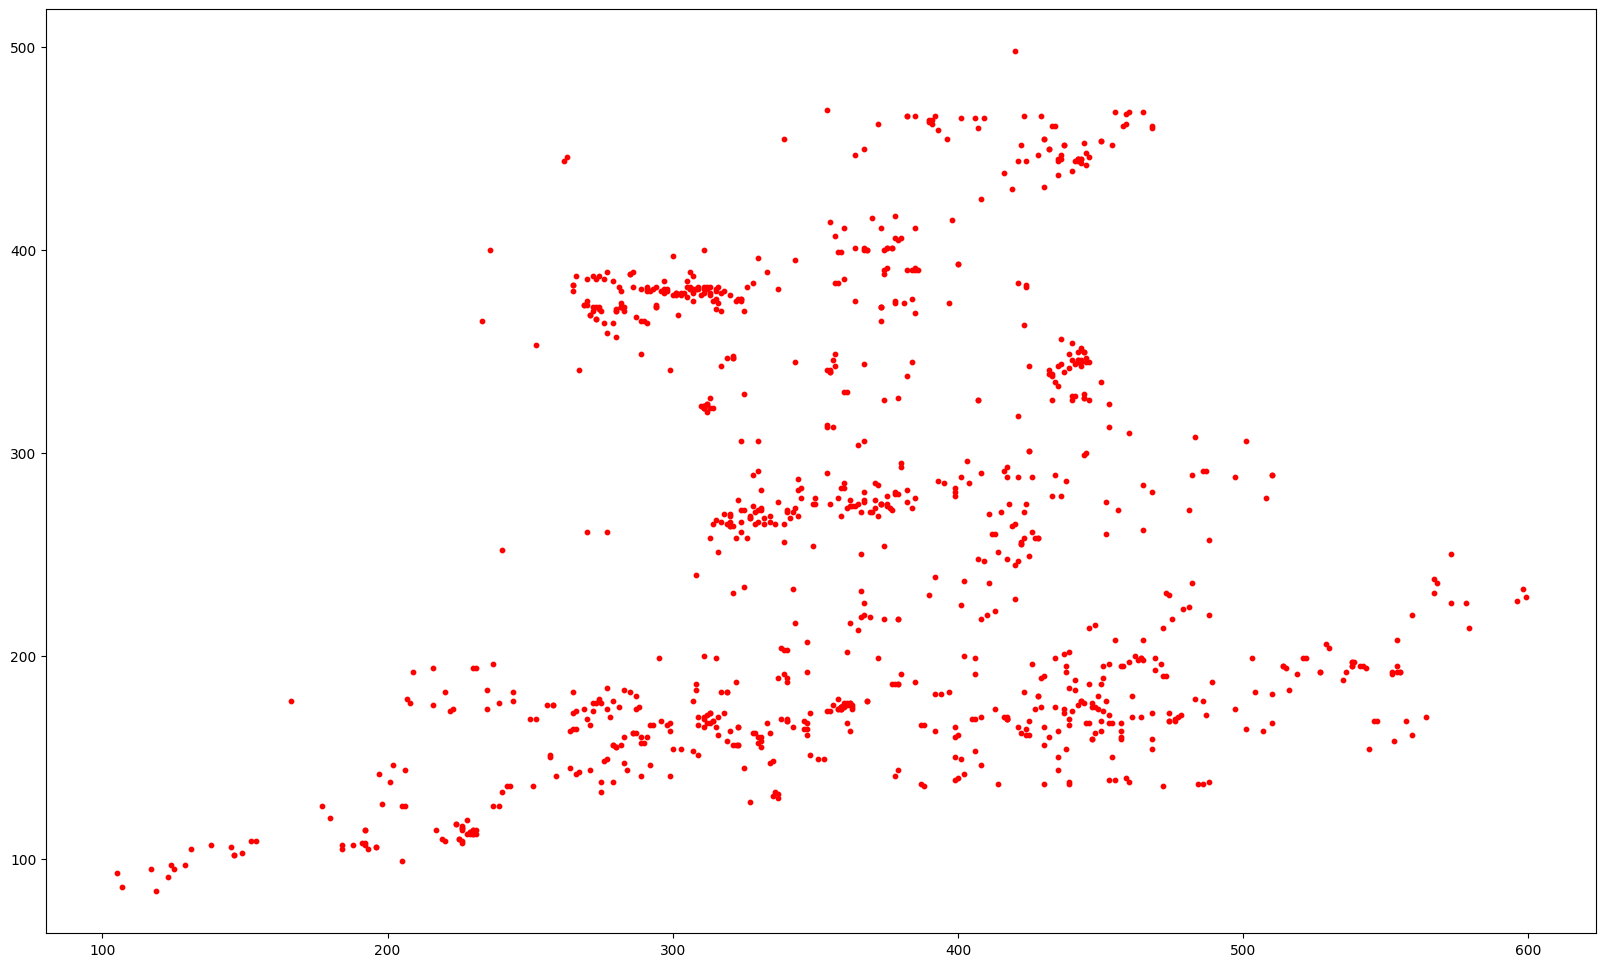

In [28]:
#sites location assuming that coords are the pixel location of the sites
#I am currently unsure of how to resolve the resolution CRS conflict to get all the points onto a map of the UK
coords = site_locations["hrv"]
x_coords = [coord[0] for coord in coords.values()]
y_coords = [coord[1] for coord in coords.values()]
#hrv["data"].isel(time=4195).plot()
ax = plt.gca()
ax.scatter(x_coords, y_coords, color="red", s=10)
plt.show()

### Defining a PyTorch Dataset

To get started, we will define a simple `IterableDataset` that shows how to slice into the PV and HRV data using `pandas` and `xarray`, respectively. You will have to modify this if you wish to incorporate non-HRV data, weather forecasts and air quality forecasts into your training regimen. If you have any questions, feel free to ask on the [ClimateHack.AI Community Discord server](https://discord.gg/HTTQ8AFjJp)!

**Note**: `site_locations` contains indices for the non-HRV, weather forecast and air quality forecast data as well as for the HRV data!

There are many more advanced strategies you could implement to load data in training, particularly if you want to pre-prepare training batches in advance or use multiple workers to improve data loading times.

In [173]:
len(site_locations["hrv"])

993

In [32]:
#The position of the sites is done based on pixels and not via a CRS system
site_locations["hrv"].values()

dict_values([(481, 224), (343, 345), (322, 187), (497, 174), (579, 214), (461, 180), (355, 414), (265, 380), (369, 219), (192, 108), (422, 255), (488, 220), (364, 401), (402, 237), (465, 208), (482, 236), (390, 230), (339, 203), (335, 131), (479, 223), (380, 191), (154, 109), (420, 245), (420, 228), (314, 375), (233, 365), (439, 202), (426, 196), (205, 99), (486, 137), (464, 199), (462, 200), (347, 164), (330, 291), (413, 174), (435, 444), (321, 231), (382, 276), (294, 372), (315, 371), (437, 201), (145, 106), (311, 323), (107, 86), (475, 218), (469, 199), (339, 455), (129, 97), (320, 378), (367, 401), (598, 233), (271, 368), (308, 381), (322, 375), (468, 154), (417, 248), (305, 377), (271, 368), (289, 157), (298, 380), (319, 347), (373, 365), (530, 204), (401, 225), (487, 171), (243, 136), (360, 411), (251, 136), (294, 373), (460, 138), (307, 375), (280, 371), (398, 415), (131, 105), (297, 379), (474, 172), (307, 178), (439, 138), (283, 147), (271, 166), (267, 143), (313, 172), (414, 

In [40]:
#If we want to create a validation dataset we will need to create something else like this for a different time period.

## Used for creating the dataloader that passes the data to the model, this needs to be changed if we want to pass in non-hrv data

In [38]:
#This function extracts the area around each individual site using the PV dicts pixel based (as in the location of sites are determined by their pixel in the image) location and then extracts an area around each site. These areas are combined, based on their timestamp,
#with the HRV data that then has its satellite imagery data extracted. This implies that the model is using subsets of the satellite imagery to train the model to make predictions for each site rather than using the whole image and then "learning" where the sites are.

class ChallengeDataset(IterableDataset):#This function sets up the data so that it can be iterated through by the CNN
    def __init__(self, pv, hrv, site_locations, sites=None):#The "self" augmentation here is used to use create a shared class between the different data types that are then iterable based on their shared timestamp
        self.pv = pv
        self.hrv = hrv
        self._site_locations = site_locations
        self._sites = sites if sites else list(site_locations["hrv"].keys())#This gets the individual site ids which are stored as the dict's keys

    def _get_image_times(self):#This function starts at the minimum date in the set and iterates up to the highest date, this is done as the data set is large and due to the nature of the parquette and xarray
        min_date = datetime(2020, 7, 1)
        max_date = datetime(2020, 7, 2)
        #max and min need to be changed if we use more than one month of data
        start_time = time(8)
        end_time = time(17)

        date = min_date#starts at the first timestamp
        while date <= max_date: #iterates through up to the max
            current_time = datetime.combine(date, start_time)
            while current_time.time() < end_time:
                if current_time:
                    yield current_time

                current_time += timedelta(minutes=60)

            date += timedelta(days=1)

    def __iter__(self):
        for time in self._get_image_times():
            first_hour = slice(str(time), str(time + timedelta(minutes=55)))#gets the time and then uses this to select the corresponding time from the pv set  

            pv_features = pv.xs(first_hour, drop_level=False)  # this gets the pv yield of the current timestamp selected earlier
            
            #pv targets defines the time span over which we are trying to make pv yield predictions
            pv_targets = pv.xs(
                slice(  # type: ignore
                    str(time + timedelta(hours=1)),
                    str(time + timedelta(hours=4, minutes=55)),
                ),
                drop_level=False,)

            hrv_data = self.hrv["data"].sel(time=first_hour).to_numpy()#gets the hrv satellite image that is associated with the first hour timestamp setting it up as an input feature

            for site in self._sites:
                try:
                    # Get solar PV features and targets, the site_targets is used to find the models loss
                    site_features = pv_features.xs(site, level=1).to_numpy().squeeze(-1)#gets the pixel based location of the pv site and then uses this to make predictions based on the individual sites
                    site_targets = pv_targets.xs(site, level=1).to_numpy().squeeze(-1)
                    assert site_features.shape == (12,) and site_targets.shape == (48,)#compresses the data from N dimensions to 12 and 48 respectively

                    # Get a 128x128 HRV crop centred on the site over the previous hour
                    x, y = self._site_locations["hrv"][site]#gets the location of the site based on the pv sites pixel level location
                    hrv_features = hrv_data[:, y - 64 : y + 64, x - 64 : x + 64, 0]
                    assert hrv_features.shape == (12, 128, 128)#crops the image to be be 128x128 around the site
                    #asset is used to force the dimensions of the extracted site level image to be the same
                    # How might you adapt this for the non-HRV, weather and aerosol data?
                except:
                    continue

                yield site_features, hrv_features, site_targets

## ##########comments are the same and this does not work yet############

Here I am including the nwp data into the dataloader using the resampled clch data (resampled only on pixel dimensions), we need to figure out a way to overcome the time resolution conflict.

In [33]:
#This function extracts the area around each individual site using the PV dicts pixel based (as in the location of sites are determined by their pixel in the image) location and then extracts an area around each site. These areas are combined, based on their timestamp,
#with the HRV data that then has its satellite imagery data extracted. This implies that the model is using subsets of the satellite imagery to train the model to make predictions for each site rather than using the whole image and then "learning" where the sites are.

#Note the IterableDataset here inherits properties from the library it is attached to
class ChallengeDataset_nwp(IterableDataset):#This function sets up the data so that it can be iterated through by the CNN
    def __init__(self, pv, hrv, knn_nwp, site_locations, sites=None):#The "self" augmentation here is used to use create a shared class between the different data types that are then iterable based on their shared timestamp
        self.pv = pv
        self.hrv = hrv
        self.knn_nwp = knn_nwp#adding the nwp xarray 
        self._site_locations = site_locations
        self._sites = sites if sites else list(site_locations["hrv"].keys())#This gets the individual site ids which are stored as the dict's keys

    def _get_image_times(self):#This function starts at the minimum date in the set and iterates up to the highest date, this is done as the data set is large and due to the nature of the parquette and xarray
        min_date = datetime(2020, 7, 1)
        max_date = datetime(2020, 7, 2) #I have changed this to see if the model works
        #max and min need to be changed if we use more than one month of data
        start_time = time(8)
        end_time = time(17)

        date = min_date#starts at the first timestamp
        while date <= max_date: #iterates through up to the max
            current_time = datetime.combine(date, start_time)
            while current_time.time() < end_time:
                if current_time:
                    yield current_time

                current_time += timedelta(minutes=60)

            date += timedelta(days=1)

    def __iter__(self):
        for time in self._get_image_times():
            first_hour = slice(str(time), str(time + timedelta(minutes=55)))#gets the time and then uses this to select the corresponding time from the pv set  

            pv_features = pv.xs(first_hour, drop_level=False)  # this gets the pv yield of the current timestamp selected earlier
            pv_targets = pv.xs(
                slice(  # type: ignore
                    str(time + timedelta(hours=1)),
                    str(time + timedelta(hours=4, minutes=55)),
                ),
                drop_level=False,
            )#pv targets defines the time span over which we are trying to make pv yield predictions

            hrv_data = self.hrv["data"].sel(time=first_hour).to_numpy()#gets the hrv satellite image that is associated with the first hour timestamp setting it up as an input feature
            
            knn_nwp_data = self.knn_nwp.sel(time=first_hour).to_numpy()
            
            for site in self._sites:
                try:
                    # Get solar PV features and targets
                    site_features = pv_features.xs(site, level=1).to_numpy().squeeze(-1)#gets the pixel based location of the pv site and then uses this to make predictions based on the individual sites
                    site_targets = pv_targets.xs(site, level=1).to_numpy().squeeze(-1)
                    combined_features = np.concatenate((hrv_features, nwp_features), axis=-1)
                    assert site_features.shape == (12,)
                    assert site_targets.shape == (48,)
                    assert combined_features.shape[1:] == (12, 128, 128) #compresses the data from N dimensions to 12 and 48 respectively

                    # Get a 128x128 HRV crop centred on the site over the previous hour
                    x, y = self._site_locations["hrv"][site]#gets the location of the site based on the pv sites pixel level location
                    hrv_features = hrv_data[:, y - 64 : y + 64, x - 64 : x + 64, 0]
                    nwp_features = knn_nwp_data[:, y - 64 : y + 64, x - 64 : x + 64]
                    assert combined_features.shape == (12, 128, 128)#crops the image to be be 128x128 around the site
                    #asset is used to force the dimensions of the extracted site level image to be the same
                    # How might you adapt this for the non-HRV, weather and aerosol data?
                except:
                    continue

                yield site_features, combined_features, site_targets

Creating a schematic for the articecture of whatever CNN/CNNs we use should be done for the final submission 


In [41]:
#This model takes the inputs of the PV data and the HRV data to make predictions for the pv based on the HRV feature data.
#This step dictates what the actual shape of the CNN is i.e how many layers, what type of connections they have, and how what the kernel size is. 
# We can load in models here from our github repo and work on them seperately, we will need to be mindfull of the fact that changing the model may require us the change the way in which we test and train them.
#
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        #sets up four convolutional layers which have increasingly large output channels
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3)#nn. is part of the pytorch model
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=96, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=96, out_channels=192, kernel_size=3)
        #Setting up the pooling layer that reduces the conv layers dimensions, we can tweak this to reduce the computational load by changing the kernel size.
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()#creates a 1D tensor (matrix) that can then be passed to the fully connected layer

        self.linear1 = nn.Linear(6924, 48)

    def forward(self, pv, hrv):#takes the inputs of the pb and the hrv data using Relu activation functions
        x = torch.relu(self.pool(self.conv1(hrv)))#passes the hrv data through the convolutional layers defined before by defining it as x.
        x = torch.relu(self.pool(self.conv2(x)))
        x = torch.relu(self.pool(self.conv3(x)))
        x = torch.relu(self.pool(self.conv4(x)))

        x = self.flatten(x)
        x = torch.concat((x, pv), dim=-1) # uses the shared dimension to combine the flattened layers (time is the shared dimension?)

        x = torch.sigmoid(self.linear1(x))#uses this to then make predictions (as the activation function is sigmoid is the model just trying to predict if the site is outputting power or not?)

        return x

In [37]:
# Import the model defined in `submission/model.py`

from submission.model import Model

# Summarises the model created above, used to sense check that the data we are passing through is correct and shows the overall structure of the model.

In [40]:
summary(Model(), input_size=[(1, 12), (1, 12, 128, 128)])#Use this to see what your model looks like before running it
#The input size here is used to prime the model summary with the input dimensions it should be expecting.
#Here we have the pv data first (1,12) it has a univariate dimension for each site with 12 dimensions per hour.
#Next we have the hrv data for each site, I think this is done as 1 observation 12 times an hour, with 128 x 128 dimension vector for the image.

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 48]                   --
├─Conv2d: 1-1                            [1, 24, 126, 126]         2,616
├─MaxPool2d: 1-2                         [1, 24, 63, 63]           --
├─Conv2d: 1-3                            [1, 48, 61, 61]           10,416
├─MaxPool2d: 1-4                         [1, 48, 30, 30]           --
├─Conv2d: 1-5                            [1, 96, 28, 28]           41,568
├─MaxPool2d: 1-6                         [1, 96, 14, 14]           --
├─Conv2d: 1-7                            [1, 192, 12, 12]          166,080
├─MaxPool2d: 1-8                         [1, 192, 6, 6]            --
├─Flatten: 1-9                           [1, 6912]                 --
├─Linear: 1-10                           [1, 48]                   332,400
Total params: 553,080
Trainable params: 553,080
Non-trainable params: 0
Total mult-adds (M): 137.13
Input size (MB): 0.79
Forward/back

## Training models

In [41]:
BATCH_SIZE = 32#This controls the number of sites that predictions are made for I think
#these are used to load in the data based on the previously defined functions above, the above functions can be altered to change how the data is ingested
dataset = ChallengeDataset(pv, hrv, site_locations=site_locations)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, pin_memory=True)#change this to alter which type of data is being loaded in

# This is for the model that uses nwp data

In [42]:
BATCH_SIZE = 32
#these are used to load in the data based on the previously defined functions above, the above functions can be altered to change how the data is ingested
dataset_nwp = ChallengeDataset_nwp(pv, hrv, knn_nwp, site_locations=site_locations)
dataloader_nwp = DataLoader(dataset_nwp, batch_size=BATCH_SIZE, pin_memory=True)#change this to alter which type of data is being loaded in
#note no need to change the DataLoader as that is a pytorch function

In [43]:
model = Model().to(device)

criterion = nn.L1Loss()#Here we are defining the test stat as MAE
optimiser = optim.Adam(model.parameters(), lr=1e-3)#Here we are defining the optimiser in this case it is ADAM 

In [52]:
EPOCHS = 1
batch_losses = []
val_losses = []
epoch_train_losses = []
epoch_val_losses = []
for epoch in range(EPOCHS):
    model.train()

    running_loss = 0.0##sets the starting loss at zero
    count = 0#is used to keep track of the number of batches passed through the training model
    for i, (pv_features, hrv_features, pv_targets) in enumerate(dataloader): 
        
        optimiser.zero_grad()#resets the gradient of all the previous weights and biases used in the model, can be changed to alter the type of optimiser we use

        predictions = model(
            pv_features.to(device, dtype=torch.float),
            hrv_features.to(device, dtype=torch.float),
        )#makes predictions based off of current batch of hrv and pv inputs

        loss = criterion(predictions, pv_targets.to(device, dtype=torch.float))#calculates the loss between the models predictions and the actual pv
        loss.backward()#backprops the loss

        optimiser.step()#updates the parameters based on the calculated loss
        ###for generating the training and test loss graph
        running_loss += loss.item() * pv_targets.size(0)
        count += pv_targets.size(0)
        
        size = int(pv_targets.size(0))#calculates the size of the first dimension of the pv_targets tensor  to determine how many data points are in the current tensor
        running_loss += float(loss) * size
        count += size
        #prints the current training loss for the first 200 data points of 32 batches, then prints again once the next 200 have been computed
        if i % 200 == 199:
            print(f"Epoch {epoch + 1}, {i + 1}: {running_loss / count}")
    epoch_train_loss = running_loss / count
    epoch_train_losses.append(epoch_train_loss)        
    print(f"Epoch {epoch + 1}: {running_loss / count}")
    
    

Epoch 1, 200: 0.13444117637351155
Epoch 1, 400: 0.14029226459097116
Epoch 1: 0.12843493451969823


NWP model training

In [235]:
EPOCHS = 1

for epoch in range(EPOCHS):
    model.train()

    running_loss = 0.0##sets the starting loss at zero
    count = 0#sets the count value for iterating to start at the zeroth point (I think this is the zeroth time slice taken earlier)
    for i, (pv_features, hrv_features, pv_targets) in enumerate(dataloader_nwp): 
        optimiser.zero_grad()#resets the gradient of all the previous weights and biases used in the model, can be changed to alter the type of optimiser we use

        predictions = model(
            pv_features.to(device, dtype=torch.float),
            hrv_features.to(device, dtype=torch.float),
        )#makes predictions based off of current batch of hrv and pv inputs

        loss = criterion(predictions, pv_targets.to(device, dtype=torch.float))#calculates the loss between the models predictions and the actual pv
        loss.backward()#backprops the loss

        optimiser.step()#updates the parameters based on the calculated loss

        size = int(pv_targets.size(0))#calculates the size of the first dimension of the pv_targets tensor  to determine how many data points are in the current tensor
        running_loss += float(loss) * size
        count += size
        #prints the current training loss for the first 200 data points, then prints again once the next 200 have been computed
        if i % 200 == 199:
            print(f"Epoch {epoch + 1}, {i + 1}: {running_loss / count}")

    print(f"Epoch {epoch + 1}: {running_loss / count}")

To validate our model we will need to create a validation dataset in the same way the training set is created as the model is sensitive to how the data is loaded into it